# Phase 3 Final Project:  Ensuring Access to Water


## Introduction

For the Phase 3 final project we will develop a model to predict water access in Tanzania using information gathered by the Tanzanian government and hosted as a competition to predict water well failure by DrivenData.  We'll depart from the competition to address the needs of our client, a local NGO working with the IMF to locate the wells at greatest risk of failure in order to determine which geographic regions to direct their funding towards.  As such, wells that use water that has been contaminated by either human activity or naturally occuring materials will also considered to be failing, as they are a health risk to the community.

## Business Understanding
Tanzania faces an increased demand for water based on population growth projections, as well as increased contamination of groundwater storage from mining, human and agricultural runoff.    A third threat is posed by changing climate conditions that have shifted rainfall patterns, causing storms producing more intense rainfall and increased flooding, leaving less water to filter into the underground aquafers and lakes from which the wells draw from.  As a result, Tanzania is in the difficult position of needing to increase access to water while also having less potable water to draw upon.  Fortunately, the World Bank has just issued the government a credt of 350 million to sponser the third phase of a Water Sector Development Program (WSDP).  With this money, "WSDP phase 3 has specific targets including connecting 9.7 million people to new water supply and 3.87 million people to rehabilitated water points. It also aims to provide basic water, sanitation and hygiene (WASH) infrastructure to 1,500 HCFs and 2,800 primary schools through rehabilitation, and 2,000 HCFs and 1,000 primary schools through new infrastructure." (https://www.worldbank.org/en/news/press-release/2022/12/14/tanzania-set-to-expand-access-to-water-supply-sanitation-and-hygiene-services-to-10-million-citizens).  More than just predicting well failure, these programs will need to determine which water sites are even viable for human consumption, as well as predict which sites will remain viable with raising sea levels affecting the salinity of groundwater  


It's important to clarify that the word well can mean many things in this dataset, from complex mechanicanical pump sites with extensive filtration to a hand pump that brings up untreated groundwater.    

Some key factors we will take into account:

__Pollution__- Which water points have harmful concentrations of pollutants

__Population__- Which water points serve the highest population density, hence putting a larger proportion of the community at risk. 

__Salinization__- Which water points are at greatest risk from sea level rise

__Sanitation__- Which water points are at greatest risk of contamination

### Data
We are given 40 independant variables (columns) from which to base our predictive model on.  There are 59,400 entries (or wells) in our training data.  Because of the high number of predictors, we'll need to examine and edit the columns we use for proccessing ease and accuracy, particularly because much of the information is duplicated throughout the dataset, leaving a high likelihood of colliniarity if left unattended to.

Our target feature, water_quality, has 32259 wells listed as "functional", 4317 wells as "in need of repair, and 22824 wells listed as"non-functional".  This immediately raises a flag for class imbalance, and is something we'll need to address as we move forward.



## Import Datasets

Our first step will be to import the neccessary libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import graphviz 


from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler

from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



Next we'll import the two datasets we'll be using for this project, Train and Target.

### Train 

In [2]:
# The independent variables for the training set
df_train_values= pd.read_csv('CSVFiles/TrainingSetValues.csv')

# Examine values
df_train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Target


In [3]:
#  The dependent variable (status_group) for each of the rows in Training set values
df_train_labels= pd.read_csv('CSVFiles/TrainingSetLabels.csv')
# Examine labels
df_train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


### Target Value Skewness
We'll check for class imbalances in our target values and determine a course of action if there is one.

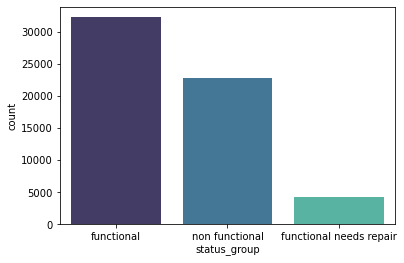

In [54]:
# Check for class imbalances
sns.countplot(x=df_train_labels['status_group'], palette= 'mako');

In [55]:
# What percent of our target variable, status_group, is functional_needs_repair?
round(df_train_labels.status_group.value_counts()/len(df_train_labels.status_group)*100, 2)


functional                 54.31
non functional             38.42
functional needs repair     7.27
Name: status_group, dtype: float64

The category of functional_needs_repair is indeed unrepresented in this data, capturing only 7% compared to functional at 54% and non functional at 38%.  Because our goal is to predict which areas will need funding to bring the local wells into fully functional status we will fold those into the non-functional category, with the assumption that in the ensuing time from the data collection (2002-2013) those small percentage of pumps that were in need of repair will still need improvement, if not outright replacement.  Additionally, model F1 scores are improved when using this strategy, as can be seen by comparing model f1 scores from the EDA section of this notebook.

In [4]:
# Replace functional_needs_repair with non_functional
df_train_labels.replace(to_replace= "functional needs repair", value= "non functional", inplace=True)



### Merge Train and Target Dataframes
Current statistical modelling libraries take in entire datasets and break out training and test samples, as well as having target features incorporated. In order to utilize these we will need to merge our dataframes

In [29]:
# Merge training and target dataframes
df= pd.merge(df_train_values, df_train_labels)

In [6]:
# Inspect
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# EDA

This section contains an abbrieviated version of our EDA, please see the Sandbox section of this Phase3_Project notebook for a full exploration.  

We'll be taking a closer look at the many independant variables here to narrow down the number of columns we use in our models.  Certain features will be easy to elimate, such as payment type, or recorded by (identifies the org. who collected the data) which will have no bearing on well functionality.  Additionally, many of the columns appear to repeat the same information, which could lead to correlation/dependency between the predictors, as well as overfitting in our model.  Therefore, narrowing down our choices will be important to the accuracy and efficacy of our model.  We will obviously want key factors, like water quality, but we'll also look at things like well depth, altitude, and source type to determine the long term viability and functionality of each well.  With sea levels rising, coastal Tanzania will be especially succeptable to salinization of it's ground water tables. There's also increading arridity in it's interior, as well as changes in rain patterns that are leading to less recharging of those aquafers.  As a result, factors like well depth, location, and source type will also be important to consider.

In [30]:
# remove wells outside Tanzanian borders
df = df[df['longitude']>= 28]

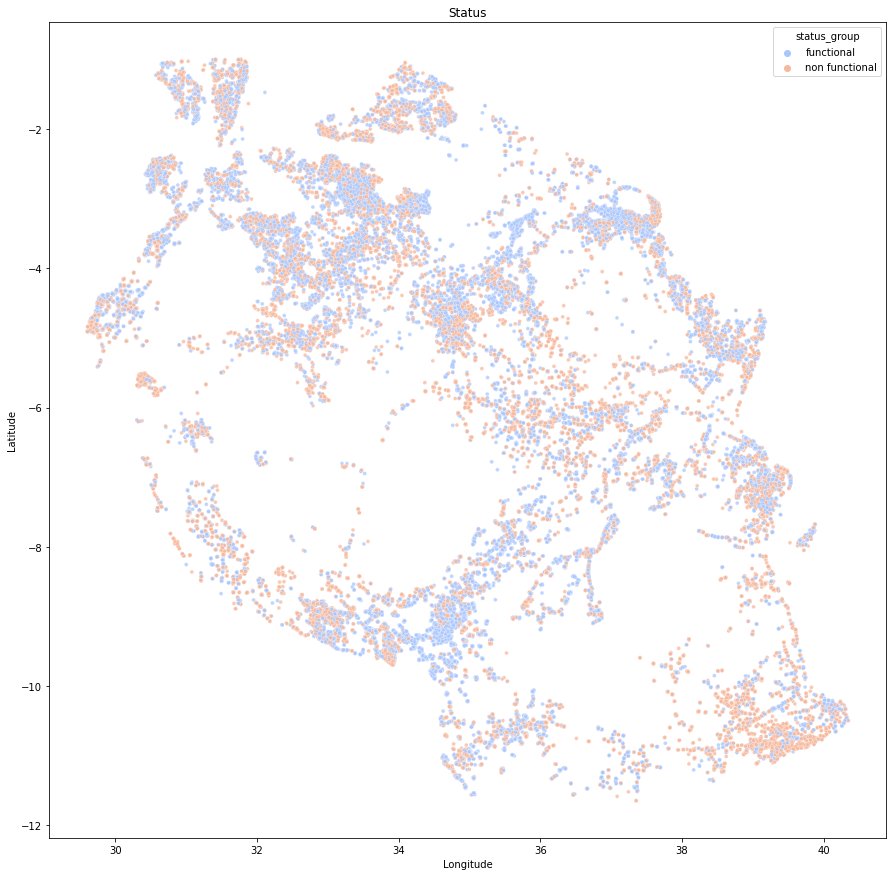

In [8]:
# Examine map of wells


plt.figure(figsize = (15, 15))
sns.scatterplot(x = 'longitude', y = 'latitude',
                hue = 'status_group', data = df, alpha = 0.75, s = 15, palette = 'coolwarm')
plt.title('Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Although there's a mix of failed and working wells throughout the country, we can see there's a heavier concentration of those in the south, where the landmass is also closest to sealevel (and the ocean) leading to increasing salinization.

## Preproccessing

### Check and Clean Columns

As the first steps in editing down our columns to the values that hold the most promise for our first model we inspected the columns to:

* Look for unneccessary or duplicate information
* Verify the data types of each column (numeric/categorical) for OHE
* Look for NaN values, which we will need to replace in order to use sklearn's decision tree and random forest



In [9]:
# Examine Dtype and non-null values
for col in df.columns:
    print(df[col].value_counts(normalize=True), '\n')


2047     0.000017
20959    0.000017
4759     0.000017
661      0.000017
2708     0.000017
           ...   
62836    0.000017
52595    0.000017
50546    0.000017
56689    0.000017
0        0.000017
Name: id, Length: 57588, dtype: float64 

0.0         0.691585
500.0       0.053865
50.0        0.042926
1000.0      0.025839
20.0        0.025405
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64 

2011-03-15    0.009933
2011-03-17    0.009690
2013-02-03    0.009464
2011-03-14    0.009030
2011-03-16    0.008908
                ...   
2004-07-01    0.000017
2004-03-06    0.000017
2004-04-05    0.000017
2011-09-20    0.000017
2011-09-09    0.000017
Name: date_recorded, Length: 353, dtype: float64 

Government Of Tanzania    0.163844
Danida                    0.057703
Hesawa                    0.035467
World Bank                0.024923
Kkkt                      0.023848
   

We determined which of our features we could drop based on duplicate or unneccessary information in our separate Early EDA file.

There were several problems that jumped out immediately in the features.  Many of the columns were duplicate values, or contained information that was functionally irrelevant for determining the status of a well.

*This leaves us with:*

__*amount_tsh*__- TSH measures the distance water travels vertically to the pump site.  70% have 0, indicating the well is actually groundwater/sourced from lakes, streams, rivers, etc.  We also see some values that might be erroneous, like 138,000, but might not be if the water is travelling through piping to a house in a town for instance.  This column may be problematic, but we'll include it in our intial logistic regression model.

__*gps_height*__- Everything looks fairly normal.  Note that some wells exist below sea level and therefor have negative values

__*latitude*__ and __*longitude*__- 

__*installer*__- Organization that installed the well

__*basin*__ - Geographic water basin: Lake Victoria, Pangani, Rufiji, Internal,
              Lake Tanganyika, Wami/Ruvu, Lake Nyasa, Ruvuma/Southern Coast, Lake Rukwa

__*district_code*__  - Geographic location (coded)

__*population*__  - Population around the well

__*gps_height*__  - Height of pump head above sea level

__*quality_group*__ - Quality of the water: good, salty, unknown, milky, colored, fluoride

__*source_class*__ - Source of the water: spring, shallow well, borehole, river/lake, 
                     rainwater harvesting, dam, other 

__*extraction_type*__- Kind of extraction at waterpoint: gravity, handpump, other, submersible,
                       motorpump, rope pump, wind-powered

In [31]:
# First edit of column selection
df1= df[['amount_tsh', 'latitude', 'installer', 'longitude', 'basin', 'district_code', 'population', 'gps_height',
                          'quality_group', 'source_class', 'extraction_type', 'construction_year', 'status_group']].copy()

# Visually inspect df1
df1

,amount_tsh,latitude,installer,longitude,basin,district_code,population,gps_height,quality_group,source_class,extraction_type,construction_year,status_group
0,6000.0,-9.856322,Roman,34.938093,Lake Nyasa,5,109,1390,good,groundwater,gravity,1999,functional
1,0.0,-2.147466,GRUMETI,34.698766,Lake Victoria,2,280,1399,good,surface,gravity,2010,functional
2,25.0,-3.821329,World vision,37.460664,Pangani,4,250,686,good,surface,gravity,2009,functional
3,0.0,-11.155298,UNICEF,38.486161,Ruvuma / Southern Coast,63,58,263,good,groundwater,submersible,1986,non functional
4,0.0,-1.825359,Artisan,31.130847,Lake Victoria,1,0,0,good,surface,gravity,0,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,-3.253847,CES,37.169807,Pangani,5,125,1210,good,groundwater,gravity,1999,functional
59396,4700.0,-9.070629,Cefa,35.249991,Rufiji,4,56,1212,good,surface,gravity,1996,functional
59397,0.0,-8.750434,NaN,34.017087,Rufiji,7,0,0,fluoride,groundwater,swn 80,0,functional
59398,0.0,-6.378573,Musa,35.861315,Rufiji,4,0,0,good,groundwater,nira/tanira,0,functional


In [11]:
# Review all columns
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57588 entries, 0 to 59399
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   amount_tsh       57588 non-null  float64
 1   latitude         57588 non-null  float64
 2   installer        53952 non-null  object 
 3   longitude        57588 non-null  float64
 4   basin            57588 non-null  object 
 5   district_code    57588 non-null  int64  
 6   population       57588 non-null  int64  
 7   gps_height       57588 non-null  int64  
 8   quality_group    57588 non-null  object 
 9   source_class     57588 non-null  object 
 10  extraction_type  57588 non-null  object 
 11  status_group     57588 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 5.7+ MB


> CLEAN TSH

In [34]:
# Calculate the mean value of the "amount_tsh" column
mean_amount_tsh = df1["amount_tsh"].mean()

# Calculate the threshold value for the top 1% values
threshold = np.percentile(df1["amount_tsh"], 99)

# Replace the top 1% values with the mean value
df1.loc[df["amount_tsh"] > threshold, "amount_tsh"] = mean_amount_tsh

> CLEAN INSTALLER

In [35]:
# Replace zero's in df (NaN values) with "other"
df1['installer'].replace('0', 'other_installer', inplace = True)

# Find and make list of top 30 installers
top_30= df1.installer.value_counts(normalize = True).head(30)

# Function to replace anything not in top_30 with "other"
def replace(column):
    return column.apply(lambda x: x if x in top_30 else 'other_installer')

# Replace values in df
df1['installer'] = replace(df['installer'])

> CLEAN QUALITY GROUP

In [36]:
# Replace all categories but "good" with "bad"
    # Define the categories to be replaced with "bad"
bad_quality = ['colored', 'fluoride', 'salty', 'milky', 'unknown']

    # Replace the categories with "bad"
df1['quality_group'] = df1['quality_group'].replace(bad_quality, 'bad')

> CLEAN EXTRACTION TYPE

In [37]:
# Replace all categories "other-..." categories with "other"
    # Define the categories to be replaced with "other"
bad_extype = ['other - play pump', 'other - mkulima/shinyanga', 'other - swn 81',
            'other - rope pump']

    # Replace the categories with "bad"
df1['extraction_type'] = df1['extraction_type'].replace(bad_extype, 'other_extraction')

> CLEAN GPS HEIGHT

In [38]:
# Drop negative sign 
df1['gps_height']= df1['gps_height'].abs()

> CLEAN CONSTRUCTION YEAR

In [44]:
# Convert "construction_year" column to numeric
df1["construction_year"] = pd.to_numeric(df1["construction_year"], errors="coerce")

# Create a new column "decade_built" and initialize it as "unknown"
df1["decade_built"] = "unknown"

# Map the decade values based on the "construction_year" column
df1.loc[df1["construction_year"] == 0, "decade_built"] = "unknown"
df1.loc[(df1["construction_year"] >= 1960) & (df1["construction_year"] < 1970), "decade_built"] = "1960"
df1.loc[(df1["construction_year"] >= 1970) & (df1["construction_year"] < 1980), "decade_built"] = "1970"
df1.loc[(df1["construction_year"] >= 1980) & (df1["construction_year"] < 1990), "decade_built"] = "1980"
df1.loc[(df1["construction_year"] >= 1990) & (df1["construction_year"] < 2000), "decade_built"] = "1990"
df1.loc[(df1["construction_year"] >= 2000) & (df1["construction_year"] < 2010), "decade_built"] = "2000"
df1.loc[df1["construction_year"] >= 2010, "decade_built"] = "2010"


In [46]:
# Drop 'construction_year' from df
df1.drop('construction_year', axis=1, inplace=True)

# Modeling

For this project we will iterate through 3 successively more complex models to reach our goal, a pipeline with tuned parameters that is able to accurately predict which water wells will fail given our independant variables.

* We'll start with a simple logistic reggression to use as our baseline
* Our second step will be to move onto a simple decision tree which will hopefully improve our f1 score. 
* Next, because of the inherent dangers of overfitting and lack of accuracy with DT's,  we'll move on to the more complex modelling strategy of random forests, with the outcomes of many combined decision trees being used to improve the accuracy (although not the run time) of our model
* We'll conclude with a pipeline that seemlessly integrates the the 3 models and runs checks for the model with the greatest accuracy

First we'll divide our data into training and test sets to prevent any data leakage before taking care of the last stages of our preprocessing: OHE and normalization.

### Train_Test_Split

In [41]:
# Split df into training and testing samples, test_size is default 25%
X= df1.drop('status_group', axis=1)
y= df1['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=18 )

Most of the variables we selected have no NaN values, which is important for the proper functioning of our models. However, we'll need to replace the 2750 missing values in "installer" with "Other" before we OHE our  categorical data.  We'll also use "Other" to replace all but the top 30 installers in the column to reduce the number of variables that will be OHE'd, thereby increasing the efficacy and accuracy of our model. 


After that we'll move on to normalize our numeric data, and LabelEncode our target data before modelling.

### OHE Train Variables

Our categorical data will need to be One Hot Encoded to use in our logistic regression

In [42]:
# Seperate df for categorical columns
X_train_categorical= X_train[['installer', 'basin', 'quality_group', 'source_class', 'extraction_type']].copy()


In [47]:
# Create OHE
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Fit OHE
ohe.fit(X_train_categorical)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_categorical),
    # index is important to ensure we can concatenate with other columns
    index=X_train_categorical.index,
    # we are dummying multiple columns at once, so stack the names
    columns=np.hstack(ohe.categories_)
)
X_train_ohe

,ACRA,AMREF,CES,Central government,Commu,Community,DANID,DANIDA,DW,DWE,...,india mark ii,india mark iii,ksb,mono,nira/tanira,other,submersible,swn 80,walimi,windmill
12632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
58158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
36758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Normalization
Becouse our numeric data has different scales our next step is to normalize it.

In [48]:
# Seperate df for numeric columns
X_train_numeric = X_train[['amount_tsh', 'latitude', 'longitude', 'district_code',
                    'population', 'gps_height']].copy()

In [49]:
# Create scaler
scaler = MinMaxScaler()

# Fit transform numeric data
scaler.fit(X_train_numeric)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numeric),
    # index is important to ensure we can concatenate with other columns
    index=X_train_numeric.index,
    columns=X_train_numeric.columns
)
X_train_scaled

,amount_tsh,latitude,longitude,district_code,population,gps_height
12632,0.004,0.778860,0.717913,0.0750,0.000492,0.331050
27434,0.100,0.051051,0.471056,0.0375,0.003213,0.185693
1490,0.002,0.457009,0.703286,0.0125,0.008197,0.167047
58158,0.100,0.905160,0.404701,0.0500,0.013115,0.498858
51941,0.000,0.254836,0.366444,0.0250,0.000000,0.000000
...,...,...,...,...,...,...
50615,0.000,0.603153,0.246652,0.0500,0.000000,0.000000
1784,0.000,0.931696,0.121697,0.0125,0.000000,0.000000
36758,0.000,0.633089,0.825657,0.0125,0.000033,0.465373
26525,0.000,0.433816,0.903754,0.5375,0.034131,0.012557


In [50]:
# Combine categorical and numeric data
X_train_full = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_train_full

,amount_tsh,latitude,longitude,district_code,population,gps_height,ACRA,AMREF,CES,Central government,...,india mark ii,india mark iii,ksb,mono,nira/tanira,other,submersible,swn 80,walimi,windmill
12632,0.004,0.778860,0.717913,0.0750,0.000492,0.331050,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27434,0.100,0.051051,0.471056,0.0375,0.003213,0.185693,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1490,0.002,0.457009,0.703286,0.0125,0.008197,0.167047,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
58158,0.100,0.905160,0.404701,0.0500,0.013115,0.498858,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51941,0.000,0.254836,0.366444,0.0250,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,0.000,0.603153,0.246652,0.0500,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1784,0.000,0.931696,0.121697,0.0125,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
36758,0.000,0.633089,0.825657,0.0125,0.000033,0.465373,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26525,0.000,0.433816,0.903754,0.5375,0.034131,0.012557,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### LabelEncode Train Target

In [52]:
# Transform y_train to string for later use with classification metrics
y_train = y_train.astype(str)


# create a LabelEncoder object
le = LabelEncoder()

# fit and transform the target variable
y_transformed = le.fit_transform(y_train)


Ok!  Now we're ready to run our models...

## 1st Model: Logistic Regression

Our first step will be to find an optimal value for c:

In [53]:
# Define the range of C values to test
c_values = [10, 100, 1000]

# Create an empty list to store the cross-validation scores for each value of C
cv_scores = []

# Loop over the different values of C and fit a LogisticRegression model for each value
for c in c_values:
    # Create a LogisticRegression object with the current value of C
    lr = LogisticRegression(C=c, max_iter=100, solver='liblinear')
    
    # Use cross-validation to evaluate the performance of the model with the current value of C
    scores = cross_val_score(lr, X_train_full, y_transformed, cv=5, scoring='accuracy')
    
    # Store the mean cross-validation score for the current value of C
    cv_scores.append(scores.mean())

# Find the value of C with the highest cross-validation score
best_c = c_values[cv_scores.index(max(cv_scores))]

# Print the best value of C
print("Best C:", best_c)


Best C: 10


In [54]:
# Create and fit logreg model
logreg = LogisticRegression(fit_intercept=False, C=10, solver='liblinear', random_state=18)
model_log = logreg.fit(X_train_full, y_transformed)
model_log

LogisticRegression(C=10, fit_intercept=False, random_state=18,
                   solver='liblinear')

In [55]:
# Check performance on train
y_pred = logreg.predict(X_train_full)

train_residuals = np.abs(y_transformed - y_pred)
accuracy = accuracy_score(y_transformed, y_pred)


print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print("Accuracy", accuracy)
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0    28672
1    14519
Name: Residuals (counts), dtype: int64
Accuracy 0.663842004121229
0    0.663842
1    0.336158
Name: Residuals (proportions), dtype: float64


Not too awful for our first try with no real tuning- our logistic model correctly identifies a well as functional about 66% of the time.  Now let's look at the f1 score:

In [56]:
# calculate f1 score
f1 = f1_score(y_transformed, y_pred)

print(f1)


0.5762978959348644


That's an ok score, but not very impressive.  If we wanted to improve our residuals or f1 score we could try feature editing by switching out our predictors, but subsequent models will do that much more effectively than we can.   Let's see if our next model can improve on that.

## 2nd Model: Simple Decision Tree

For our next model we'll create a CART classifier, which will be able to handle our numeric and categorical data, and will help us identify the most important categories of our data for predicting well failure.  We'll adjust the max_depth for our hyperparameter tuning and measuring the r-squared values on our train and test samples to keep overfitting/underfitting to a minimum.  

In [57]:
# Train and fit a DT classifier
dtc = DecisionTreeClassifier(random_state=18, max_depth=5, splitter='best')  
dtc.fit(X_train_full, y_transformed)

DecisionTreeClassifier(max_depth=5, random_state=18)

In [58]:
# Check f1 score
y_hat_train = dtc.predict(X_train_full)
f1 = f1_score(y_transformed, y_hat_train)

print(f1)

0.6402595515955644


That's not very good...rather than manually attempt to prune our tree using max_depth, let's see what happens if we try adjusting the depth from 1-25 and cross validating our models to find the best bias-varience trade-off, meaning it may not give it's best predictions with our training data (bias) so as to not underperform due to overfitting on our test data (variance)...

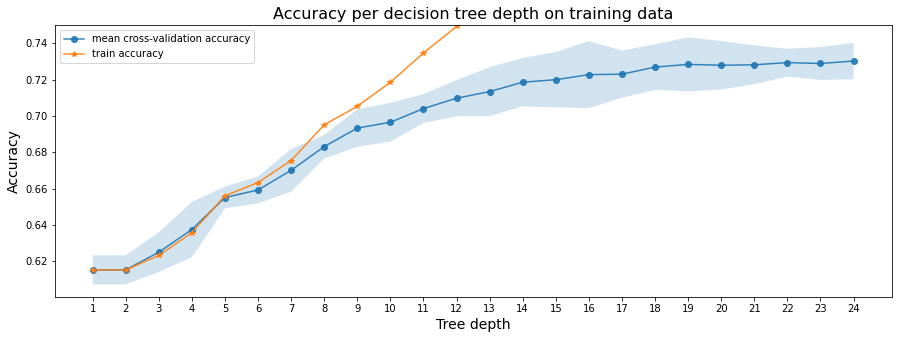

In [81]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train_full, y_transformed, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')




In [82]:
# Determine best depth using cross-val accuracy 
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))


The depth-24 tree achieves the best mean cross-validation accuracy 73.01751 +/- 0.5003% on training dataset


Let's try again, this time using the reccommended depth of 24

In [59]:
# Create and fit dt model
dtc = DecisionTreeClassifier(random_state=18, max_depth=24, splitter='best')  
dtc.fit(X_train_full, y_transformed)

DecisionTreeClassifier(max_depth=24, random_state=18)

In [60]:
# Check f1 score
y_hat_train = dtc.predict(X_train_full)
f1 = f1_score(y_transformed, y_hat_train)

print(f1)

0.9184420944028887


Impressive! Our model is now capable of determining well failure with 92 % accuracy.  DecisionTree models are known for overfitting though, and it might be wise to use a RandomForest to ensure our model will perform well when using the test data.  Accuracy will be of the utmost importance, because our non-profit has a limited budget and is looking to to target those areas that are at greatest risk for well failure, and to use the data from this report to appeal for more funding.  Access to clean water is a life or death matter, much in the same way that identifying cancer is- erring on the side caution (more false positives/wells identified as failing is preferable to more false negatives/wells that are failing but identified as functional).

## 3rd Model: Random Forest

For our final model we'll use a Random Forest to see if we can prevent the overfitting inherent to Decision Trees while also improving our f1 score.  We'll start by randomly choosing a max_depth to prevent our model from overfitting.

In [61]:
# Create and fit rfc
rfc= RandomForestClassifier(random_state=18, max_depth=6)
rfc.fit(X_train_full, y_transformed)

RandomForestClassifier(max_depth=6, random_state=18)

In [62]:
# Check f1 score
y_hat_train = rfc.predict(X_train_full)
f1 = f1_score(y_transformed, y_hat_train, average='weighted')

print(f1)

0.6736074912798173


Now let's try again using a grid search to define the best parameters for our RFC.  We'll use max_depth, min_samples_split, and min_samples_leaf as the variables in our grid

In [87]:
# Create rfc for param grid
rfc2= RandomForestClassifier(random_state=18)
rfc2.fit(X_train_full, y_transformed)

RandomForestClassifier(random_state=18)

In [88]:
# Define the parameter grid for the grid search
param_grid = {
    "n_estimators": [10, 20, 30],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(rfc2, param_grid, cv=5)
grid_search.fit(X_train_full, y_transformed)

# Print the best parameters and best F1 score
print("Best Parameters: ", grid_search.best_params_)
print("Best F1 Score: ", grid_search.best_score_)

# Predict the target variable on the preprocessed training data
y_train_pred_encoded = grid_search.best_estimator_.predict(X_train_full)

# Reverse label encoding on the predicted labels
y_train_pred = le.inverse_transform(y_train_pred_encoded)



Best Parameters:  {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 30}
Best F1 Score:  0.7527494180734743


In [63]:
# Create rfc with best params
rfc3= RandomForestClassifier(random_state=18, max_depth=18, min_samples_split=5, n_estimators=30 )
rfc3.fit(X_train_full, y_transformed)

RandomForestClassifier(max_depth=18, min_samples_split=5, n_estimators=30,
                       random_state=18)

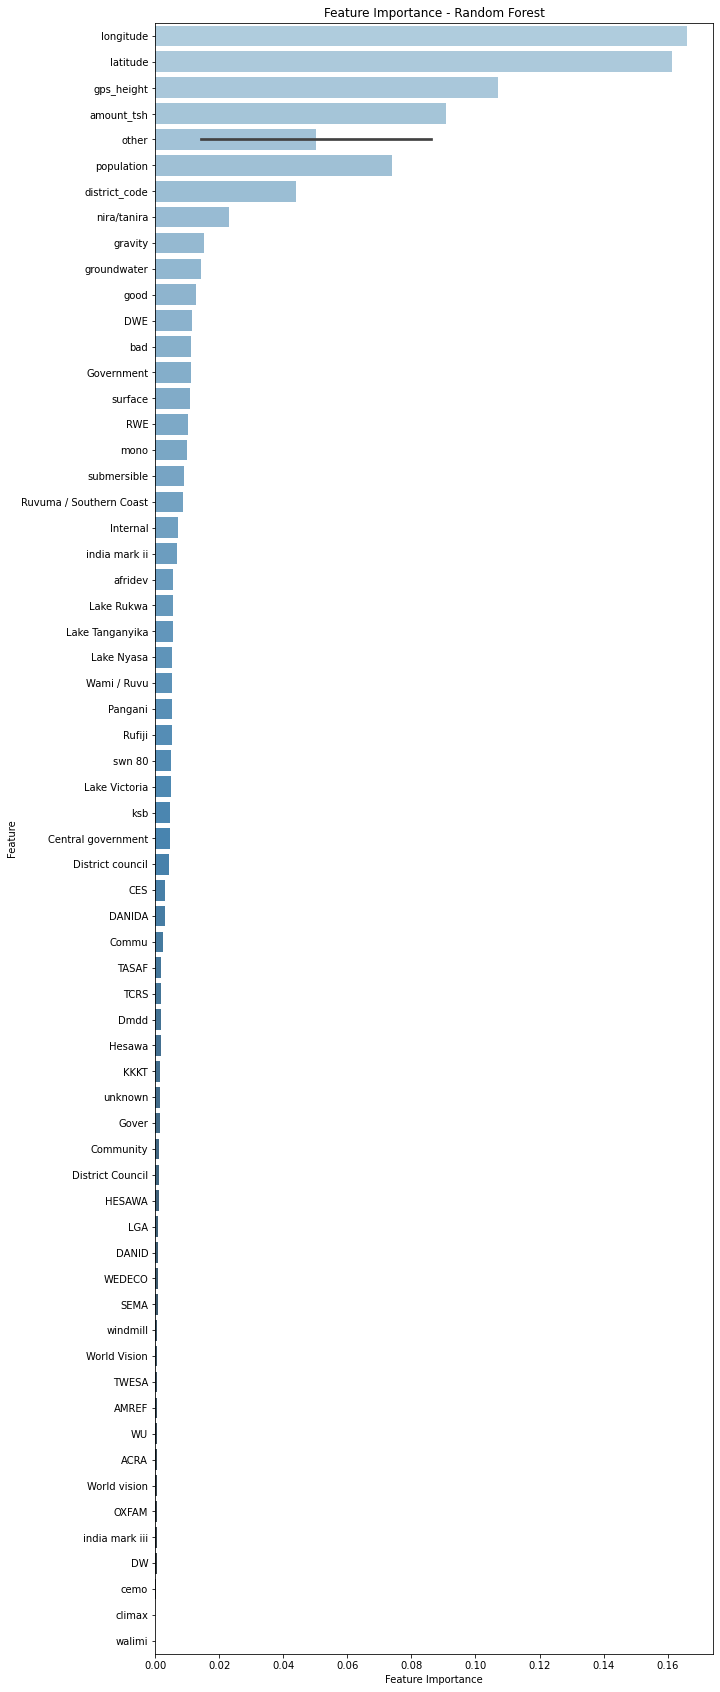

In [67]:
# Get feature importances from the random forest model
importances = rfc3.feature_importances_

# Get the corresponding feature names
feature_names = X_train_full.columns

# Create a DataFrame with feature names and importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance values
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 30))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.show()


In [90]:
# Check f1 score
y_hat_train = rfc3.predict(X_train_full)
f1 = f1_score(y_transformed, y_hat_train, average='weighted')

print(f1)

0.8566391884573489


Our f1 score is lower here, but that may mean that our earlier DT model was overfitting, and wouldn't perform well on our test data.  In order to determine which of our models is truely the best we'll need to pull all our techniques into a pipeline to compare and contrast the test outcomes now that we've determined how to tune our hyperparameters.

## Pipeline

Now let's put our modelling methods together in a pipeline, and use it to run a comparison of f1 scores.

In [101]:
# Split data into training and test sets
X_train_pipeline, X_test_pipeline, y_train_pipeline, y_test_pipeline = train_test_split(X, y, random_state=18)

# Define preprocessing steps for numerical and categorical data
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())  # Normalizing numeric data
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder())  # One-hot encoding categorical data
])

# Create the column transformer to apply the preprocessing steps
preprocessor = ColumnTransformer([
    ("numeric", numeric_transformer, numeric_features),
    ("categorical", categorical_transformer, categorical_features)
])

# Encode the target variable
label_encoder = LabelEncoder()
y_train_pipeline = label_encoder.fit_transform(y_train_pipeline)

# Define the models
logistic_regression = LogisticRegression(random_state=18,
                                         fit_intercept=False, C=10,
                                         solver='liblinear')
decision_tree = DecisionTreeClassifier(random_state=18,
                                       max_depth=24,
                                       splitter='best')
random_forest = RandomForestClassifier(random_state=18,
                                       max_depth=18,
                                       min_samples_split=5,
                                       n_estimators=30)

# Create the pipelines for each model
pipelines = [
    ("Logistic Regression", Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", logistic_regression)
    ])),
    ("Decision Tree", Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", decision_tree)
    ])),
    ("Random Forest", Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", random_forest)
    ]))
]

for model_name, pipeline in pipelines:
    pipeline.fit(X_train_pipeline, y_train_pipeline)
    y_pred = pipeline.predict(X_train_pipeline)
    f1 = f1_score(y_train_pipeline, y_pred)
    print(f"{model_name} F1 Score: {f1}")

Logistic Regression F1 Score: 0.576231613355125
Decision Tree F1 Score: 0.9184420944028887
Random Forest F1 Score: 0.8302597330675084


# Classification Metrics

For our models, it will be important to both capture both as many possible well failures as we can (recall) and to be sure that our predictions are accurate (precision scoore), Fortunately, we can use a F1 score (the harmonic mean of accuracy and recall) to do so.  

We'll use our preprocessing pipeline to to handle the test data.

In [107]:
# Use same preprocessing steps for Test numerical and categorical data
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())  # Normalizing numeric data
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder())  # One-hot encoding categorical data
])

# Create the column transformer to apply the preprocessing steps
preprocessor = ColumnTransformer([
    ("numeric", numeric_transformer, numeric_features),
    ("categorical", categorical_transformer, categorical_features)
])

# Encode the target variable
label_encoder = LabelEncoder()
y_test_pipeline = label_encoder.fit_transform(y_test_pipeline)

# Define the models
logistic_regression = LogisticRegression(random_state=18,
                                         fit_intercept=False, C=10,
                                         solver='liblinear')
decision_tree = DecisionTreeClassifier(random_state=18,
                                       max_depth=24,
                                       splitter='best')
random_forest = RandomForestClassifier(random_state=18,
                                       max_depth=18,
                                       min_samples_split=5,
                                       n_estimators=30)

# Create the pipelines for each model
pipelines = [
    ("Logistic Regression", Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", logistic_regression)
    ])),
    ("Decision Tree", Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", decision_tree)
    ])),
    ("Random Forest", Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", random_forest)
    ]))
]

# Fit and evaluate each model
for model_name, pipeline in pipelines:
    pipeline.fit(X_test_pipeline, y_test_pipeline)
    y_pred = pipeline.predict(X_test_pipeline)
    f1 = f1_score(y_test_pipeline, y_pred)
    
    print(f"{model_name} F1 Score: {f1}")
    print(f"{model_name} Accuracy: {accuracy_score(y_test_pipeline, y_pred)}")

Logistic Regression F1 Score: 0.5639776213679841
Logistic Regression Accuracy: 0.664374522469959
Decision Tree F1 Score: 0.8971780733052223
Decision Tree Accuracy: 0.911926095714385
Random Forest F1 Score: 0.8371859296482413
Random Forest Accuracy: 0.864971869139404


__Analysis here__

# Conclusion

### Findings

Note that our train and test data performed roughly as well as each other for all three models, including our dtc.  This means that our best model, the dtc, was capable of determining well failure about 90% of the time.  Although that number could be improved by using a black box method, like a XGboost pipeline, it is helpful in this case to be able to examine some of the decisions made by our model in determining which of our predictors would lead to the greatest information gain/loss in entropy, and in examining the Gini Index, a metric to measure how often a randomly chosen element would be incorrectly identified.  We want to be able to convey which of our variables were most relevant so that we can use that information to identify potential areas of concern, both literally in the geographic sense, but also categorically, like identifying a particular installer or TSH level that correlate strongly with well failure.  We'll be able to do this by looking at the graphviz plot included in the EDA file of this notebook. Those decisions highest up on the tree contain the highest information gain- they are the factors which matter most in determining which wells will fail.

From that graph, as well as our EDA we can see that:






In [39]:
# Check performance on test data
y_hat_test = logreg.predict(X_test_full)

test_residuals = np.abs(y_transformed - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))


0    9651
1    5199
Name: Residuals (counts), dtype: int64

0    0.649899
1    0.350101
Name: Residuals (proportions), dtype: float64


### Predictions/Next Steps

Our best model was able to accurately predict well failure about 90% of the time.  But because the consequences of loosing water access are so dire, we should really be looking for ways to boost out models performance in order to get the most accurate picture possible for which wells can be relied upon.  While we were able to extract a great deal of information from using our white box DTC, the next step should be to run a blackbox model, like XGBoost, that will most certainly enhance our models performance.  Using these combined methods, we can make informed decisions about which variables are most closely connected to well failure, as well as have the added accuracy of ensemble methods. 




## Thank You

Thanks to Flatiron for the learning opportunity, and in particular Abhineet Kulkarni for the unceasing support he provided.  Please see the list of resources used and code attributions below.

1. Pipeline sample code:  https://www.kdnuggets.com/2017/12/managing-machine-learning-workflows-scikit-learn-pipelines-part-1.html

2. DTC vs. RFC: https://www.kdnuggets.com/2022/02/random-forest-decision-tree-key-differences.html

3. Classification Metrics: https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226

4. Running multiple models: https://www.knowledgehut.com/blog/data-science/combining-models-machine-learning-with-python

5. CrossVal sample: https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6

6. Crosstab: https://pbpython.com/pandas-crosstab.html